# Setup

In [1]:
import sys
# sys.path.append("/kaggle/input/python-helpers/") # Comment this out when you are not in Kaggle kernel
sys.path.append("../") # Comment this out when you are in local environment
import utils
from utils import (
    # General Functions
    check_memory_usage, check_memory_by_global_variable, # For memory handling
    get_time_now, cprint, # For logging
    get_cols, downcast_to_32bit, my_concat, my_power, my_log, list_diff, # For preprocessing
    plot_feature_importance, plot_scatterplot, # For visualization
    get_feature_summary, # For feature engineering & feature selection
    check_auc, plot_heatmap, # For EDA
    # Competition Constants
    META_COLUMNS, 
    # Competition Functions
    read_data, read_model, # Data Ingestion
    filter_df, check_target_dependency, # EDA
    calculate_psi, run_chi_square_tests, # Validation
    train_lgbm, # Model Training
    percentile, clean_df, get_price_clippers, get_volume_clippers, clip_df, # Pre-processing: Clean & Clip
    calc_robust_scale, calc_std_scale, scale_base_columns,  # Pre-processing: Scaling
    setup_validation_zip, # Simulation
    lgbm_inference_by_batch, # Inference
    zero_sum, # Post-processing
)
from utils import (
    calc_intraday_gradient
)

In [2]:
import gc
import joblib
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=12)
# import plotly.express as px
import random
import scipy.cluster.hierarchy as sch
import seaborn as sns
import time
import catboost
from catboost import CatBoostRegressor, Pool

from datetime import datetime
from itertools import combinations, groupby, product
from scipy.stats import pearsonr, chi2_contingency
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
%load_ext autoreload
%autoreload

In [4]:
DATA_DIR = '../data/'

In [5]:
joblib.__version__

'1.3.2'

# Tree-Based Model Training

In [6]:
%%time
# Read the final dataframe from feature engineering notebook
train_path = f"{DATA_DIR}/optiver-train-data/train_by_batch_gen_v6.parquet"
train = read_data(train_path)
train = downcast_to_32bit(train)

Before downcast: 	RAM used: 1.1 GB


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:01<00:00, 56.50it/s]

After downcast: 	RAM used: 1.2 GB
CPU times: user 8.72 s, sys: 17.8 s, total: 26.6 s
Wall time: 23.9 s


In [7]:
# Set the target columns to avoid target leakage into X_train
target_column_list = get_cols(train, "target", excludes=["normalized", "daily", "grad"])
target_column_list

['target', 'clipped_target', 'is_positive_target', 'is_mild_target']

In [8]:
# # Get the list of features to avoid based on previous experiments / analysis
# corr_but_noob_features = joblib.load("../features_summary/corr_but_noob_features.pkl")
# print(corr_but_noob_features[:10])

In [9]:
# lgbm_model = read_model(f'{DATA_DIR}/optiver-lgbm-models/lgbm_model7.txt')
# imp_df = plot_feature_importance(lgbm_model.feature_name(), lgbm_model.feature_importance(), return_df=True)
# low_imp_features = imp_df.loc[imp_df["feature_importance"] < 140, "feature"].tolist()

In [10]:
def get_final_features(df, noob_features=[], target_columns=target_column_list, meta_columns=META_COLUMNS[:2]):
    return list_diff(df.columns, noob_features + target_columns + meta_columns)

In [11]:
train.shape

(5237760, 392)

## LGBM 

In [23]:
LGBM_MODEL_VERSION = 11
lgbm_val_model_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}_val.txt'
lgbm_val_data_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}_val.csv'
lgbm_final_model_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}.txt'

In [24]:
# val_model = read_model(lgbm_final_model_path)

### Optuna Tuning (Ignore this first)

In [25]:
imp_df = read_data("../imp_df.parquet")
best_features = joblib.load("../features.pkl")

In [26]:
imp_df = imp_df.loc[imp_df["feature"].isin(best_features)].reset_index(drop=True)

In [27]:
imp_df.shape

(562, 3)

In [28]:
# These are be the static hyperparams for our ML problem + your machine specifications
lgbm_general_settings = dict(
    objective='mae', 
    histogram_pool_size=256, 
    force_col_wise=True, 
    random_state=1020,
    max_bin=512, 
    n_jobs=-1, 
    verbose=-1
)

In [29]:
def objective(trial):
    cprint(f"{get_time_now()} Suggesting hyparameters for this trial...", color="green")
    lgbm_trial_params = dict(
        boosting_type="gbdt", # trial.suggest_categorical("boosting_type", []),
        learning_rate=trial.suggest_float("learning_rate", 0.005, 0.0125), # 0.018052307589575444, 
        max_depth=trial.suggest_categorical("max_depth", [11, 12, -1]), 
        n_estimators=4000, # trial.suggest_int("n_estimators", 2000, 3000, step=100),
        num_leaves=trial.suggest_int("num_leaves", 250, 450, step=50), 
        reg_alpha=trial.suggest_float("reg_alpha", 0.03, 0.1, log=True), # 0.02216069565875271, 
        reg_lambda=trial.suggest_float("reg_lambda", 2, 10, log=True), # 0.01223572246957101,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.45, 0.7),
        subsample=trial.suggest_float("subsample", 0.7, 0.9),
        min_child_samples=trial.suggest_int("min_child_samples", 2, 16, step=2),
        min_split_gain=0.25, # trial.suggest_float("min_split_gain", 0.2, 0.3),
        verbose=-1
    )
    final_lgbm_params = lgbm_general_settings | lgbm_trial_params
    print(final_lgbm_params)
    
    num_features = 500 # trial.suggest_int("num_features", 500, 50, step=10)
    feature_list = imp_df.iloc[:num_features]["feature"].tolist()
    
    val_model, valid_pred, best_score = train_lgbm(
        data=train, train_start_date=1, train_end_date=420, val_start_date=421, 
        es=True, get_val_pred=True, feature_list=feature_list, lgbm_params=final_lgbm_params
    )
    return best_score

In [30]:
# joblib.dump(study, "../study.pkl")

In [20]:
# study3 = optuna.create_study(direction="minimize")
# study3.optimize(objective, n_trials=25)

In [21]:
# joblib.dump(study3, "../tuning_result/lgbm_optuna3.pkl")

In [22]:
# plot_scatterplot(study_df, x_col="temp", y_col="value", ticksize=17)

In [23]:
# study_df = study3.trials_dataframe()
# study_df = study_df.loc[study_df["state"] == "COMPLETE"]
# # study_df.to_csv(f"../optuna_trials.csv", index=False)
# fig, ax = plt.subplots(3, 3, figsize=(21, 16))
# ax = ax.ravel()
# for i, col in enumerate(get_cols(study_df, "params")):
#     sns.scatterplot(data=study_df, x=study_df[col], y=study_df["value"], ax=ax[i])
# plt.suptitle("Optuna Tuning Result", y=0.9)
# plt.savefig("../tuning_result/lgbm_optuna_result2.png")
# plt.show()

### First Training for Validation 

In [31]:
lgbm_study = joblib.load("../tuning_result/lgbm_optuna2.pkl")

In [32]:
# These are be the static hyperparams for our ML problem + your machine specifications
lgbm_general_settings = dict(
    n_estimators=2300, 
    min_split_gain=0.25, 
    objective='mae', 
    histogram_pool_size=128, 
    force_col_wise=True, 
    random_state=1020,
    max_bin=400, 
    n_jobs=-1, 
    verbose=-1
)

In [33]:
lgbm_params = lgbm_study.best_params
lgbm_params["learning_rate"] = 0.01

In [34]:
# # We manually set here, but this can be str8 away came from optuna best hyper-params
# lgbm_params = {
#     'boosting_type': 'gbdt', 
#     'learning_rate': 0.0165,
#     'max_depth': 12,
#     'n_estimators': 1000,
#     'num_leaves': 420, 
#     'reg_alpha': 0.3,
#     'reg_lambda': 1,
#     'colsample_bytree': 0.65,
#     'subsample': 0.7,
#     'min_child_samples': 16,
#     'min_split_gain': 0.2,  
#     'min_child_weight': 0.001, 
#     "device": "cpu"
# }

In [35]:
# Final hyper-params set
full_lgbm_params = lgbm_general_settings | lgbm_params
print(full_lgbm_params)

{'n_estimators': 2300, 'min_split_gain': 0.25, 'objective': 'mae', 'histogram_pool_size': 128, 'force_col_wise': True, 'random_state': 1020, 'max_bin': 400, 'n_jobs': -1, 'verbose': -1, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 400, 'reg_alpha': 0.03509689562307177, 'reg_lambda': 5.183354801921556, 'colsample_bytree': 0.6949832282432649, 'subsample': 0.748072282616451, 'min_child_samples': 10}


In [36]:
feature_list = list_diff(train.columns.tolist(), META_COLUMNS[:2] + target_column_list + imp_df.iloc[-50:]["feature"].tolist() + get_cols(train, endswith="flag"))
# feature_list = imp_df.loc[:300, "feature"].tolist()
len(feature_list)

373

In [37]:
gc.collect()

834

In [33]:
# %%time
# val_model, valid_pred, best_score = train_lgbm(
#     data=train, train_start_date=10, train_end_date=420, val_start_date=421, 
#     es=True, get_val_pred=True, feature_list=feature_list, lgbm_params=full_lgbm_params
# )

22:13:08 Preparing Dataset...
22:14:04 Training...
Training until validation scores don't improve for 230 rounds
[50]	training's l1: 6.42276	training's mae: 6.42276	valid_0's l1: 5.75739	valid_0's mae: 5.75739
[100]	training's l1: 6.37768	training's mae: 6.37768	valid_0's l1: 5.7315	valid_0's mae: 5.7315
[150]	training's l1: 6.35013	training's mae: 6.35013	valid_0's l1: 5.71793	valid_0's mae: 5.71793
[200]	training's l1: 6.32999	training's mae: 6.32999	valid_0's l1: 5.70957	valid_0's mae: 5.70957
[250]	training's l1: 6.31242	training's mae: 6.31242	valid_0's l1: 5.70306	valid_0's mae: 5.70306
[300]	training's l1: 6.29699	training's mae: 6.29699	valid_0's l1: 5.69838	valid_0's mae: 5.69838
[350]	training's l1: 6.28317	training's mae: 6.28317	valid_0's l1: 5.69455	valid_0's mae: 5.69455
[400]	training's l1: 6.27032	training's mae: 6.27032	valid_0's l1: 5.69207	valid_0's mae: 5.69207
[450]	training's l1: 6.25746	training's mae: 6.25746	valid_0's l1: 5.68978	valid_0's mae: 5.68978
[500]	tr

In [34]:
5.67831 / 5.98804

0.9482752286223873

In [35]:
5.6816085 / 5.9931046

0.9480242510701383

In [ ]:
learn: 5.9931046	test: 5.6816085	best: 5.6811794 (2168)

In [31]:
lgbm_val_model_path, lgbm_val_data_path

('../data//optiver-lgbm-models/lgbm_model11_val.txt',
 '../data//optiver-lgbm-models/lgbm_model11_val.csv')

In [35]:
val_model.save_model(lgbm_val_model_path)

In [37]:
valid_pred.to_csv(lgbm_val_data_path, index=False)

In [31]:
val_model = read_model(lgbm_val_model_path)

### Train for Submission (Final Model) 

In [32]:
# Use back the same features, so that the validation score holds
best_new_features = feature_list # best_features

In [33]:
# Can update the number of trees if the early stopping get hit during validation, because we have no holdout set for early stopping when we train using Date ID 1 - 480
best_lgbm_params = full_lgbm_params
best_lgbm_params["n_estimators"] = 2500 # int(val_model.best_iteration * 1.1)
best_lgbm_params

{'n_estimators': 2500,
 'min_split_gain': 0.25,
 'objective': 'mae',
 'histogram_pool_size': 128,
 'force_col_wise': True,
 'random_state': 1020,
 'max_bin': 400,
 'n_jobs': -1,
 'verbose': -1,
 'learning_rate': 0.01,
 'max_depth': 11,
 'num_leaves': 400,
 'reg_alpha': 0.03509689562307177,
 'reg_lambda': 5.183354801921556,
 'colsample_bytree': 0.6949832282432649,
 'subsample': 0.748072282616451,
 'min_child_samples': 10}

In [34]:
train = train.loc[:, META_COLUMNS[:2] + best_new_features + target_column_list]

In [35]:
gc.collect()

29

In [36]:
%%time
lgbm_model, _, _ = train_lgbm(
    data=train, train_start_date=50, train_end_date=480, val_start_date=478, val_end_date=480, 
    es=False, get_val_pred=False, feature_list=best_new_features, lgbm_params=best_lgbm_params
)

00:02:41 Preparing Dataset...
00:03:37 Training...
[50]	training's l1: 6.43904	training's mae: 6.43904	valid_0's l1: 5.22582	valid_0's mae: 5.22582
[100]	training's l1: 6.39583	training's mae: 6.39583	valid_0's l1: 5.19985	valid_0's mae: 5.19985
[150]	training's l1: 6.36942	training's mae: 6.36942	valid_0's l1: 5.184	valid_0's mae: 5.184
[200]	training's l1: 6.3504	training's mae: 6.3504	valid_0's l1: 5.17209	valid_0's mae: 5.17209
[250]	training's l1: 6.33329	training's mae: 6.33329	valid_0's l1: 5.16122	valid_0's mae: 5.16122
[300]	training's l1: 6.31852	training's mae: 6.31852	valid_0's l1: 5.15214	valid_0's mae: 5.15214
[350]	training's l1: 6.3054	training's mae: 6.3054	valid_0's l1: 5.14386	valid_0's mae: 5.14386
[400]	training's l1: 6.29274	training's mae: 6.29274	valid_0's l1: 5.13609	valid_0's mae: 5.13609
[450]	training's l1: 6.28056	training's mae: 6.28056	valid_0's l1: 5.12877	valid_0's mae: 5.12877
[500]	training's l1: 6.26913	training's mae: 6.26913	valid_0's l1: 5.12148	v

In [38]:
lgbm_final_model_path

'../data//optiver-lgbm-models/lgbm_model11.txt'

In [39]:
%%time
lgbm_model.save_model(lgbm_final_model_path)

CPU times: user 1.8 s, sys: 557 ms, total: 2.35 s
Wall time: 403 ms


In [40]:
gc.collect()

593

## CatBoost

In [12]:
def train_catboost(data, feature_list, cat_params, train_target="clipped_target", train_start_date=0, train_end_date=420, val_start_date=421, val_end_date=480, 
                   es=True, es_min_delta=5e-5, eval_freq=25, get_val_pred=True):
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    tr = filter_df(data, date_id=(train_start_date, train_end_date), seconds=(0, 540)).reset_index(drop=True)
    va = filter_df(data, date_id=(val_start_date, val_end_date), seconds=(0, 540)).reset_index(drop=True)

    X_tr = tr.loc[:, feature_list]
    y_tr = tr[train_target]
    X_va = va.loc[:, feature_list]
    y_va = va["target"]
    del tr
    gc.collect()
    
    cat_general_settings = dict(
        loss_function='MAE', 
        random_state=923,
        task_type="CPU", 
        verbose=1
    )
    
    if es:
        es_settings = {
            'use_best_model': True, 
            'od_type': "Iter",
            'od_wait': int(cat_params["iterations"] * 0.1),
            'metric_period': eval_freq
        }
        cat_general_settings = cat_general_settings | es_settings
    
    full_cat_params = cat_general_settings | cat_params
        
    cprint(f"{get_time_now()}, Start training using hyperparams: {full_cat_params}", color="green")
    model = CatBoostRegressor(**full_cat_params)
    model.fit(
        X_tr, 
        y_tr,
        eval_set=Pool(X_va, y_va)
    )
    gc.collect()
    
    if get_val_pred:
        cprint(f"{get_time_now()} Getting Validation Prediction...", color="green")
        val_df = va.loc[:, META_COLUMNS + ["target"]].reset_index(drop=True)
        val_df["val_pred"] = model.predict(X_va)
    else:
        val_df = pd.DataFrame()
    
    return model, val_df

In [13]:
CAT_MODEL_VERSION = "4"
cat_val_model_path = f"{DATA_DIR}/optiver-catboost-models/cat_model{CAT_MODEL_VERSION}_val.cbm"
cat_val_data_path = f'{DATA_DIR}/optiver-catboost-models/cat_model{CAT_MODEL_VERSION}_val.csv'
cat_final_model_path = f"{DATA_DIR}/optiver-catboost-models/cat_model{CAT_MODEL_VERSION}.cbm"

### Optuna Tuning

In [14]:
cat_params = {
    'iterations': 1200,
    'learning_rate': 0.05,
    'depth': 11,
    'subsample': 0.88,
    'colsample_bylevel': 0.85,
    'min_data_in_leaf': 12,
    'l2_leaf_reg': 3.98,
    'border_count': 150,
    'mvs_reg': 2.645,
    'sampling_frequency': 'PerTreeLevel',
    'langevin': True,
    'grow_policy': 'SymmetricTree',
    'bootstrap_type': 'MVS',
}

In [15]:
def objective(trial):
    # Set the hyperparameter range to tune
    params = dict(
        iterations=2000, # trial.suggest_int("iterations", 2000, 2500, step=250),
        learning_rate=0.01, # trial.suggest_float("learning_rate", 0.003, 0.03, log=True),
        depth=trial.suggest_int("depth", 10, 12, step=1),
        subsample=trial.suggest_float("subsample", 0.8, 0.95),
        colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.7, 0.9),
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 2, 10, step=4),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1, 4),
        border_count=trial.suggest_int("border_count", 60, 100, step=20),
        nan_mode="Max", # trial.suggest_categorical("nan_mode", ["Min", "Max"]),
        sampling_frequency="PerTree", # trial.suggest_categorical("sampling_frequency", ["PerTree", "PerTreeLevel"]),
        langevin=True, # trial.suggest_categorical("langevin", [True, False]),
        mvs_reg=trial.suggest_float("mvs_reg", 0.1, 3, log=True),
        loss_function="MAE", 
        grow_policy="SymmetricTree",
        bootstrap_type="MVS", 
        od_type="Iter",
        od_wait=150,
        metric_period=25,
        random_state=999, 
        verbose=0,
    )
    is_clip_target = trial.suggest_categorical("clip_target", [True, False])
    if is_clip_target:
        y_tr = tr["clipped_target"]
    else:
        y_tr = tr["target"]
    cprint(f"{get_time_now()}, Hyperparams: {params}", color="green")
    model = CatBoostRegressor(**params)
    model.fit(
        X_tr, 
        y_tr,
        eval_set=Pool(X_va, y_va)
    )
    cprint(f"{get_time_now()}, Done Training, Predicting Now...", color="green")
    y_va_pred = model.predict(X_va)
    mae = (y_va_pred - y_va).abs().mean()
    return mae

In [16]:
# # study2 = optuna.create_study(direction="minimize")
# study2.optimize(objective, n_trials=10)

In [17]:
# joblib.dump(study2, "../tuning_result/catboost_optuna2.pkl")

In [18]:
# study_df = study2.trials_dataframe()
# study_df = study_df.loc[study_df["state"] == "COMPLETE"]
# # study_df.to_csv(f"../optuna_trials.csv", index=False)
# fig, ax = plt.subplots(4, 3, figsize=(21, 16))
# ax = ax.ravel()
# for i, col in enumerate(get_cols(study_df, "params")):
#     sns.scatterplot(data=study_df, x=study_df[col], y=study_df["value"], ax=ax[i])
# plt.suptitle("Optuna Tuning Result", y=0.9)
# plt.savefig("../tuning_result/cat_optuna_result2.png")
# plt.show()

### Train for Validation

In [19]:
study2 = joblib.load("../tuning_result/catboost_optuna.pkl")

In [20]:
prev_catboost_val_model = read_model(f"{DATA_DIR}/optiver-catboost-models/cat_model4_val.cbm")
prev_catboost_val_model

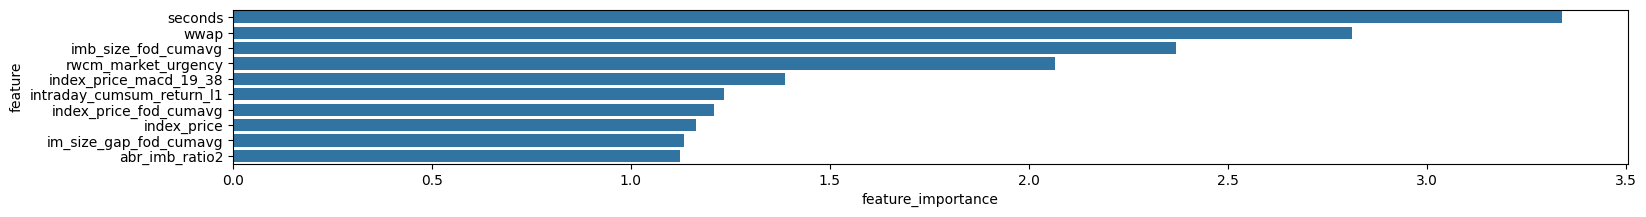

In [21]:
cat_imp_df = plot_feature_importance(prev_catboost_val_model.feature_names_, prev_catboost_val_model.get_feature_importance(), return_df=True, limit=10, figsize=(18, 2))

In [22]:
feature_list = list_diff(train.columns.tolist(), META_COLUMNS[:2] + target_column_list + cat_imp_df.iloc[-30:]["feature"].tolist() + get_cols(train, endswith="flag"))
# feature_list = imp_df.loc[:300, "feature"].tolist()
len(feature_list)

355

In [23]:
# These are be the static hyperparams for our ML problem + your machine specifications
cat_general_settings = dict(
    loss_function='MAE', 
    random_state=923,
    task_type="CPU", 
    verbose=1
)

In [24]:
# We manually set here, but this can be str8 away came from optuna best hyper-params
cat_params = {
    'iterations': 2600,
    'learning_rate': 0.015,
    'depth': 12,
    'subsample': 0.8,
    'colsample_bylevel': 0.75,
    'min_data_in_leaf': 12,
    'l2_leaf_reg': 3.21,
    'border_count': 128,
    'mvs_reg': 2.5,
    'sampling_frequency': 'PerTreeLevel',
    'langevin': True,
    'grow_policy': 'SymmetricTree',
    'bootstrap_type': 'MVS',
    # 'max_leaves': 300,
    'diffusion_temperature': 10000,
    'nan_mode': "Max", 
}

In [25]:
# Final hyper-params set
full_cat_params = cat_general_settings | cat_params
print(full_cat_params)

{'loss_function': 'MAE', 'random_state': 923, 'task_type': 'CPU', 'verbose': 1, 'iterations': 2600, 'learning_rate': 0.015, 'depth': 12, 'subsample': 0.8, 'colsample_bylevel': 0.75, 'min_data_in_leaf': 12, 'l2_leaf_reg': 3.21, 'border_count': 128, 'mvs_reg': 2.5, 'sampling_frequency': 'PerTreeLevel', 'langevin': True, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'diffusion_temperature': 10000, 'nan_mode': 'Max'}


In [26]:
len(feature_list)

355

In [33]:
%%time
cat_val_model, cat_valid_pred = train_catboost(
    data=train, train_start_date=10, train_end_date=420, val_start_date=421, 
    es=True, get_val_pred=True, feature_list=feature_list, cat_params=full_cat_params
)

12:19:42 Preparing Dataset...
12:21:49, Start training using hyperparams: {'loss_function': 'MAE', 'random_state': 923, 'task_type': 'CPU', 'verbose': 1, 'use_best_model': True, 'od_type': 'Iter', 'od_wait': 260, 'metric_period': 25, 'iterations': 2600, 'learning_rate': 0.015, 'depth': 12, 'subsample': 0.8, 'colsample_bylevel': 0.75, 'min_data_in_leaf': 12, 'l2_leaf_reg': 3.21, 'border_count': 128, 'mvs_reg': 2.5, 'sampling_frequency': 'PerTreeLevel', 'langevin': True, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'diffusion_temperature': 10000, 'nan_mode': 'Max'}


0:	learn: 6.5083195	test: 5.8131136	best: 5.8131136 (0)	total: 3.55s	remaining: 2h 33m 46s
25:	learn: 6.4497570	test: 5.7729012	best: 5.7729012 (25)	total: 1m 12s	remaining: 1h 59m 59s
50:	learn: 6.4154601	test: 5.7503889	best: 5.7503889 (50)	total: 2m 20s	remaining: 1h 57m 21s
75:	learn: 6.3934955	test: 5.7370719	best: 5.7370719 (75)	total: 3m 30s	remaining: 1h 56m 30s
100:	learn: 6.3781771	test: 5.7287636	best: 5.7287636 (100)	total: 4m 41s	remaining: 1h 56m 16s
125:	learn: 6.3656976	test: 5.7226958	best: 5.7226958 (125)	total: 5m 53s	remaining: 1h 55m 40s
150:	learn: 6.3552705	test: 5.7180734	best: 5.7180734 (150)	total: 7m 3s	remaining: 1h 54m 25s
175:	learn: 6.3464440	test: 5.7141952	best: 5.7141952 (175)	total: 8m 14s	remaining: 1h 53m 31s
200:	learn: 6.3387999	test: 5.7115637	best: 5.7115637 (200)	total: 9m 24s	remaining: 1h 52m 16s
225:	learn: 6.3313486	test: 5.7090094	best: 5.7090094 (225)	total: 10m 35s	remaining: 1h 51m 12s
250:	learn: 6.3248586	test: 5.7068385	best: 5.70683

In [36]:
cat_val_model_path, cat_val_data_path

('../data//optiver-catboost-models/cat_model4_val.cbm',
 '../data//optiver-catboost-models/cat_model4_val.csv')

In [37]:
cat_val_model.save_model(cat_val_model_path)

In [38]:
cat_valid_pred.to_csv(cat_val_data_path, index=False)

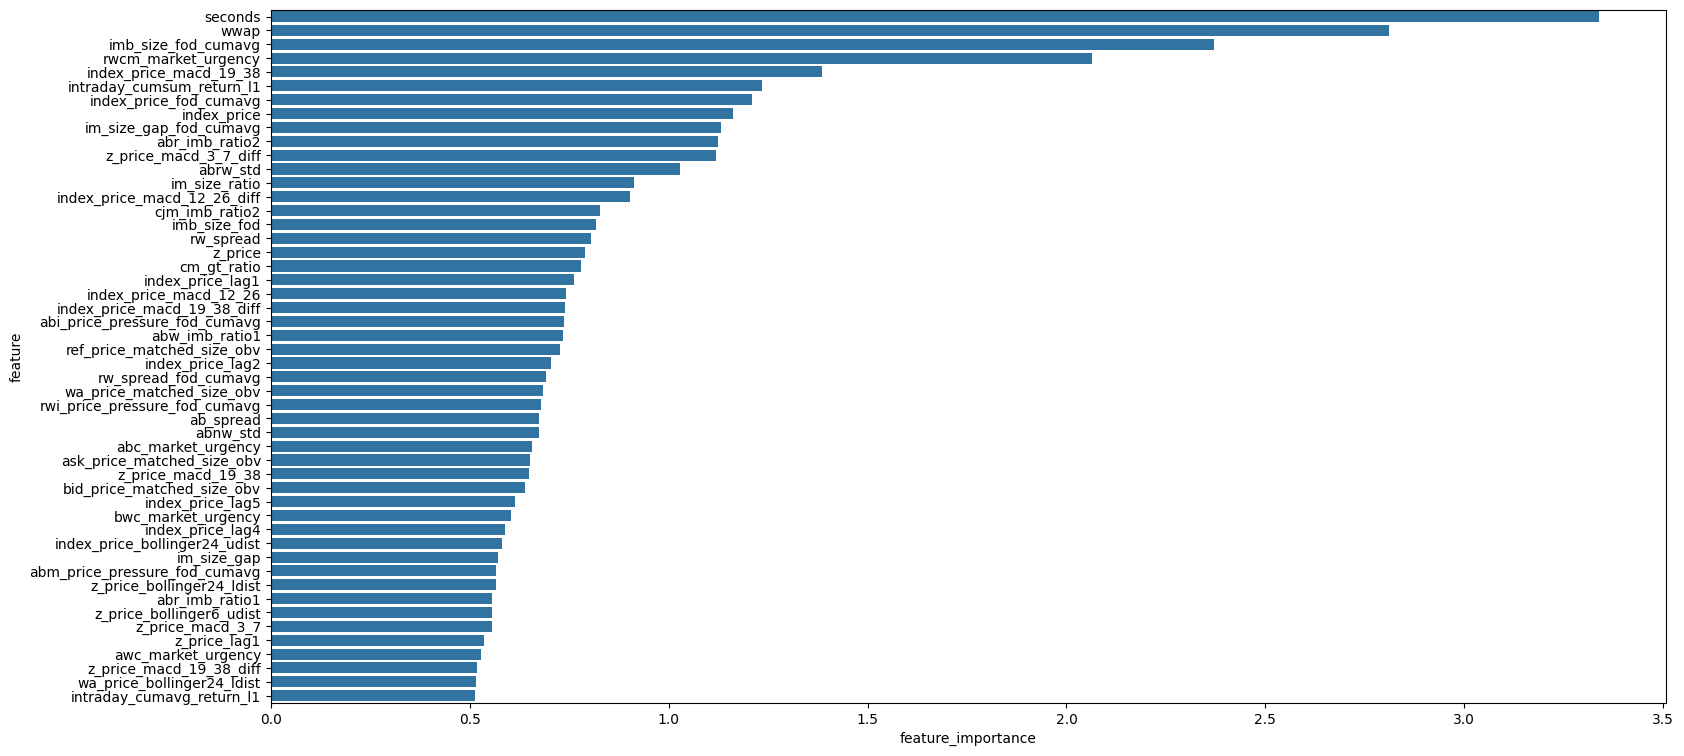

In [39]:
cat_imp_df = plot_feature_importance(cat_val_model.feature_names_, cat_val_model.get_feature_importance(), return_df=True, limit=50, figsize=(18, 9))

### Train for Submission (Final Model)

In [28]:
cat_val_model = read_model(cat_val_model_path)

In [30]:
# Can update the number of trees if the early stopping get hit during validation, because we have no holdout set for early stopping when we train using Date ID 1 - 480
best_cat_params = full_cat_params
best_cat_params["iterations"] = int(2168 * 1.1) # cat_val_model.best_iteration_
best_cat_params["use_best_model"] = False
best_cat_params

{'loss_function': 'MAE',
 'random_state': 923,
 'task_type': 'CPU',
 'verbose': 1,
 'iterations': 2384,
 'learning_rate': 0.015,
 'depth': 12,
 'subsample': 0.8,
 'colsample_bylevel': 0.75,
 'min_data_in_leaf': 12,
 'l2_leaf_reg': 3.21,
 'border_count': 128,
 'mvs_reg': 2.5,
 'sampling_frequency': 'PerTreeLevel',
 'langevin': True,
 'grow_policy': 'SymmetricTree',
 'bootstrap_type': 'MVS',
 'diffusion_temperature': 10000,
 'nan_mode': 'Max',
 'use_best_model': False}

In [31]:
gc.collect()

6270

In [ ]:
%%time
cat_final_model, _ = train_catboost(
    data=train, train_start_date=50, train_end_date=480, val_start_date=477, val_end_date=480, 
    es=False, get_val_pred=False, feature_list=feature_list, cat_params=full_cat_params
)

16:06:50 Preparing Dataset...
16:08:43, Start training using hyperparams: {'loss_function': 'MAE', 'random_state': 923, 'task_type': 'CPU', 'verbose': 1, 'iterations': 2384, 'learning_rate': 0.015, 'depth': 12, 'subsample': 0.8, 'colsample_bylevel': 0.75, 'min_data_in_leaf': 12, 'l2_leaf_reg': 3.21, 'border_count': 128, 'mvs_reg': 2.5, 'sampling_frequency': 'PerTreeLevel', 'langevin': True, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'diffusion_temperature': 10000, 'nan_mode': 'Max', 'use_best_model': False}
0:	learn: 6.5203587	test: 5.2676002	best: 5.2676002 (0)	total: 3.08s	remaining: 2h 2m 22s
1:	learn: 6.5175890	test: 5.2658335	best: 5.2658335 (1)	total: 6.18s	remaining: 2h 2m 40s
2:	learn: 6.5147153	test: 5.2640451	best: 5.2640451 (2)	total: 9.1s	remaining: 2h 25s
3:	learn: 6.5119577	test: 5.2623557	best: 5.2623557 (3)	total: 12.3s	remaining: 2h 2m 24s
4:	learn: 6.5091607	test: 5.2606367	best: 5.2606367 (4)	total: 15.2s	remaining: 2h 42s
5:	learn: 6.5065720	test: 5.25

In [ ]:
cat_final_model.save_model(cat_final_model_path)

In [132]:
final_model.save_model(final_model_path)

## Try R1 R2 Models

In [35]:
train_r1 = filter_df(train, seconds=(0, 290), reset_index=True)
train_r2 = filter_df(train, seconds=(300, 540), reset_index=True)
train_r1 = train_r1.dropna(how="all", axis=1)
assert (train_r1.shape[0] + train_r2.shape[0]) == train.shape[0], "Not Tally"

r1_features = get_final_features(train_r1, corr_but_noob_features, target_columns=target_column_list)
r2_features = get_final_features(train_r2, corr_but_noob_features, target_columns=target_column_list)
len(r1_features), len(r2_features)

(271, 320)

In [38]:
%%time
val_model_r2, valid_pred_r2, best_score = train_lgbm(
    data=train_r2, train_start_date=0, train_end_date=420, val_start_date=421, 
    es=True, get_val_pred=True, feature_list=r2_features, lgbm_params=final_lgbm_params
)

11:26:37 Preparing Dataset...
11:26:44 Training...
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 5.65184	training's mae: 5.65184	valid_0's l1: 4.9485	valid_0's mae: 4.9485
[200]	training's l1: 5.54782	training's mae: 5.54782	valid_0's l1: 4.93295	valid_0's mae: 4.93295
[300]	training's l1: 5.46663	training's mae: 5.46663	valid_0's l1: 4.92811	valid_0's mae: 4.92811
[400]	training's l1: 5.39743	training's mae: 5.39743	valid_0's l1: 4.92629	valid_0's mae: 4.92629
[500]	training's l1: 5.33653	training's mae: 5.33653	valid_0's l1: 4.92631	valid_0's mae: 4.92631
Early stopping, best iteration is:
[448]	training's l1: 5.36747	training's mae: 5.36747	valid_0's l1: 4.92575	valid_0's mae: 4.92575
Evaluated only: l1
11:35:00 Getting Validation Prediction...
CPU times: user 52min 45s, sys: 10min 45s, total: 1h 3min 31s
Wall time: 8min 26s


In [ ]:
final_val = pd.concat([valid_pred_r1, valid_pred_r2], ignore_index=True)
final_val = final_val.merge(train[META_COLUMNS + ["target"]], on=META_COLUMNS, how="left")
final_val = final_val.merge(va[META_COLUMNS + ["lgbm_v7_pred"]], on=META_COLUMNS, how="left")
final_val["avg"] = (final_val["lgbm_v7_pred"] + final_val["val_pred"]) / 2

# Feature Analysis

In [13]:
all_logp = pd.read_csv("../features_summary/features_logp_values.csv")
all_logp.head()

,stock_id,date_id,seconds,ab_gap,ab_gap_ar_gap_fod_ratio,ab_gap_ar_gap_fod_spread,ab_gap_ar_gap_fod_sum,ab_gap_aw_gap_fod_ratio,ab_gap_aw_gap_fod_spread,ab_gap_aw_gap_fod_sum,...,abm_imb_ratio3,price_pressure,market_urgency,wwap,abm_imb_ratio1,bim_imb_ratio3,bw_depth_pressure,am_st_ratio,weight,ab_st_ratio
0,0,-461.57883,-389.206270,-187.82472,-25.712883,-70.565020,-71.720665,-7.982771,-31.442432,-39.312466,...,-15.109345,-199.10718,-105.01898,-41.105220,-15.693370,-69.164055,-9.284789,-38.769245,0.0,-8.999992
1,1,-255.99847,-50.908030,-95.85843,-1.970455,-31.303220,-18.432371,-7.302582,-58.321200,-107.524920,...,-2.285080,-34.22804,-745.00000,-56.152970,-2.340367,-55.779106,-373.447080,-140.826050,0.0,-483.384340
2,2,-285.27423,-60.181583,-226.42468,-1.753751,-57.731570,-32.764600,-15.509977,-67.374170,-194.751070,...,-5.372412,-132.27824,-745.00000,-69.289580,-5.385533,-54.519524,-422.289370,-184.418170,0.0,-438.427280
3,3,-476.75760,-417.776340,-167.16582,-8.670104,-68.847800,-52.333294,-3.675680,-40.057570,-42.837223,...,-7.751771,-196.29108,-151.11436,-26.448440,-7.775989,-69.673400,-27.209745,-26.891043,0.0,-30.637623
4,4,-296.97943,-285.855220,-128.71718,-23.655752,-33.396355,-18.730232,-4.442601,-29.449490,-52.478240,...,-5.359083,-91.10555,-223.43639,-33.808147,-5.362135,-45.823254,-83.076580,-33.435528,0.0,-95.377370


In [16]:
all_logp = all_logp.set_index("stock_id")

In [28]:
all_logp_agg = 0.5 * all_logp.median() + 0.25 * (all_logp.apply(percentile(0.75)) + all_logp.apply(percentile(0.25)))

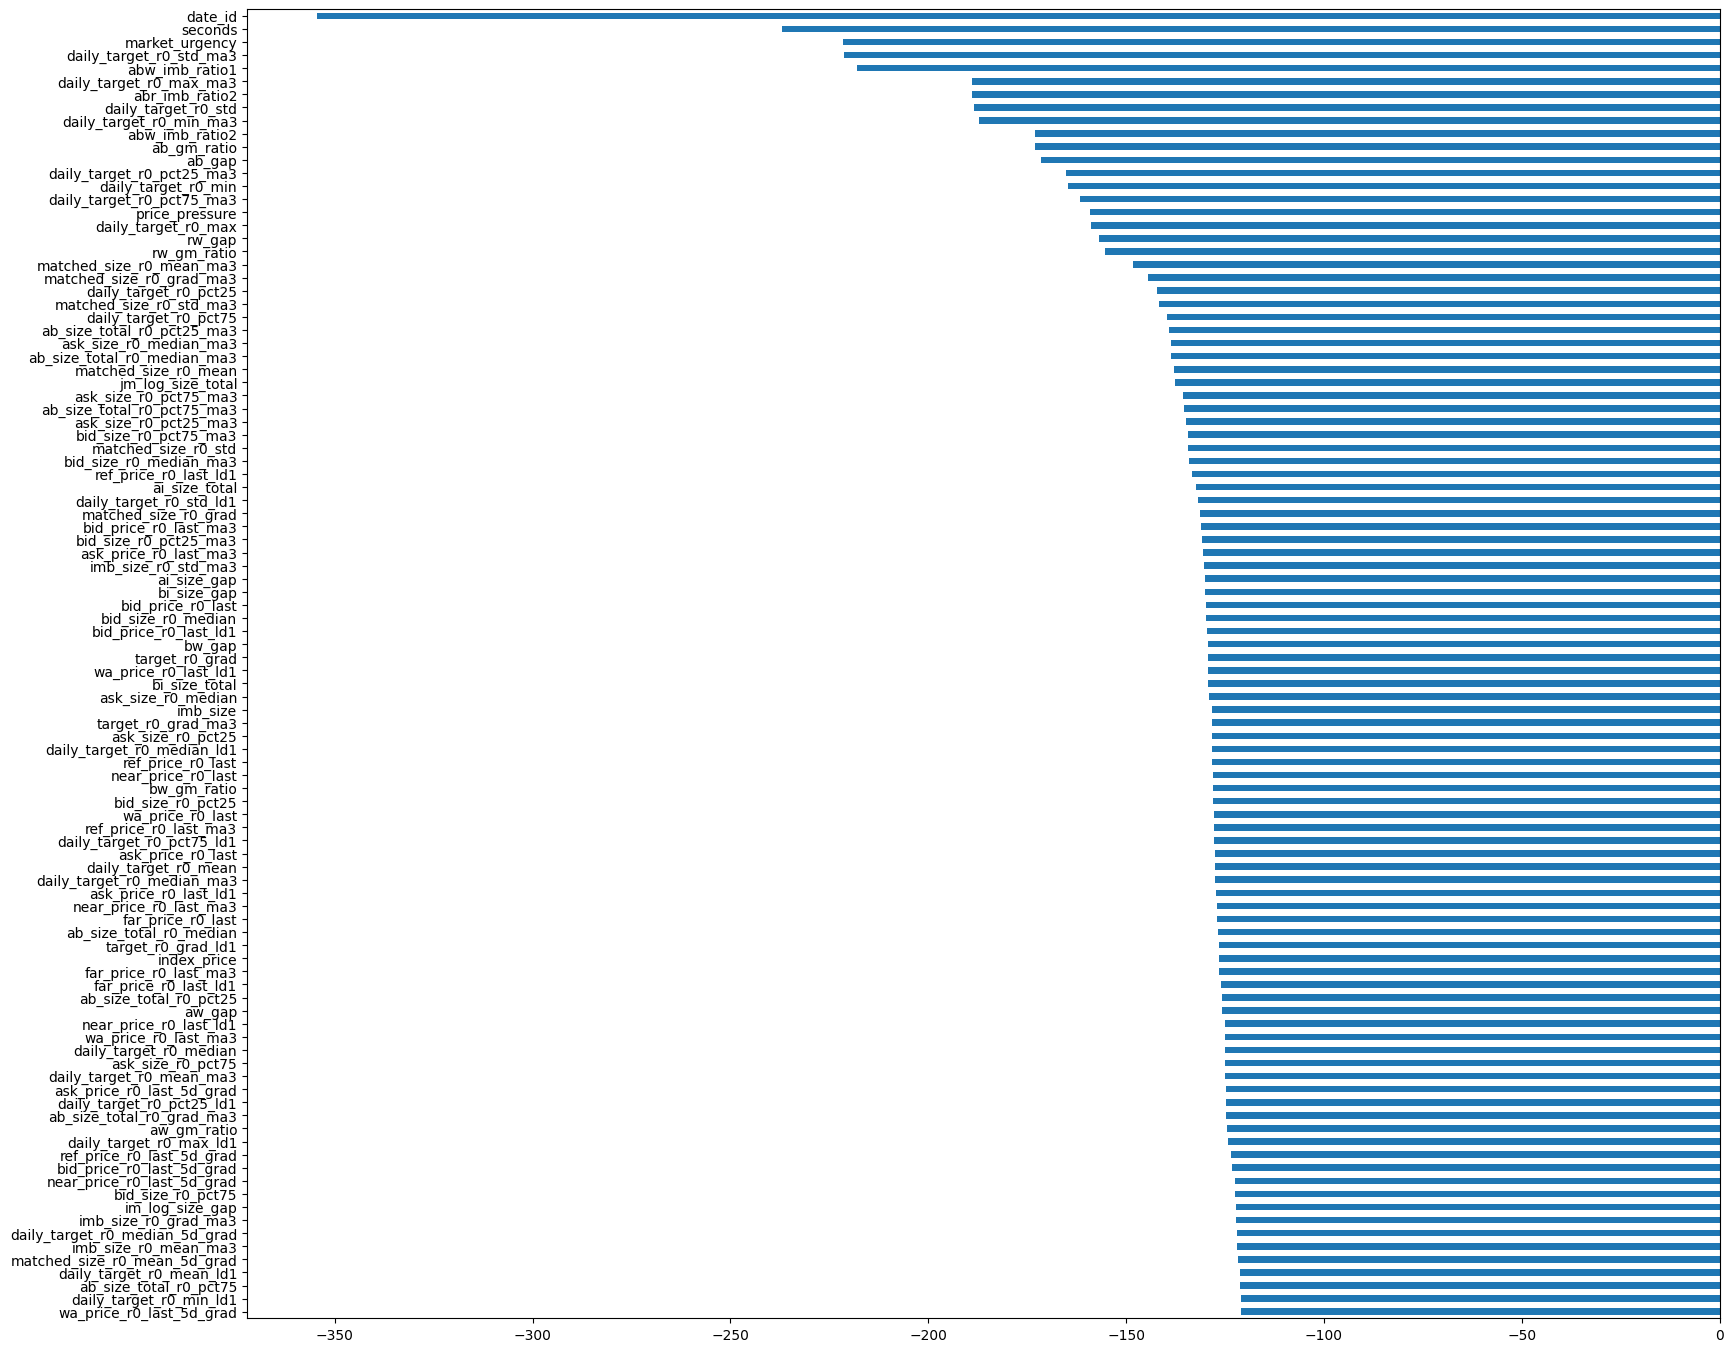

In [38]:
plt.figure(figsize=(19, 17))
all_logp_agg.sort_values()[:100][::-1].plot.barh()
plt.show()

# Error Analysis

# Test Simple Averaging Ensemble

In [54]:
cat_val_data_path

'../data//optiver-catboost-models/cat_model4_val.csv'

In [55]:
lgbm_val_data_path

'../data//optiver-lgbm-models/lgbm_model11_val.csv'

In [59]:
cat = read_data(cat_val_data_path)
lgbm = read_data(lgbm_val_data_path)
lgbm["cat_pred"] = cat["val_pred"]
lgbm["final_pred"] = (.5 * lgbm["cat_pred"] + .5 * lgbm["val_pred"])
lgbm = lgbm.merge(train[META_COLUMNS + ["bid_size", "ask_size", "matched_size", "c_size_gap"]], on=META_COLUMNS, how="left")
lgbm["p_final_pred2"] = zero_sum(
    lgbm["final_pred"], 
    lgbm['bid_size'] + lgbm['ask_size']
)
(lgbm["p_final_pred2"] - lgbm["target"]).abs().mean()

5.677203936390783

In [61]:
(lgbm["val_pred"] - lgbm["target"]).abs().mean()

5.6783083552097855

In [60]:
(lgbm["cat_pred"] - lgbm["target"]).abs().mean()

5.682252642882694

In [180]:
c1 = read_data("../data/optiver-catboost-models/cat_model2_val.csv")
l1 = read_data("../data/optiver-lgbm-models/lgbm_model8_val.csv")

In [181]:
lgbm["cat_pred1"] = c1["cat_pred"]
lgbm["val_pred1"] = l1["val_pred"]

In [182]:
lgbm["final_pred"] = 0.25 * (lgbm["cat_pred1"] + lgbm["cat_pred"] + lgbm["val_pred"] + lgbm["val_pred1"])
(lgbm["final_pred"] - lgbm["target"]).abs().mean()

5.677299856265766

In [192]:
lgbm["p_final_pred2"] = zero_sum(
    lgbm["final_pred"], 
    lgbm["ask_size"] * np.abs(my_log(lgbm["ask_size_rbtsc"])) + lgbm["bid_size"] * np.abs(my_log(lgbm["bid_size_rbtsc"]))
)
(lgbm["p_final_pred2"] - lgbm["target"]).abs().mean()

5.677356032170784

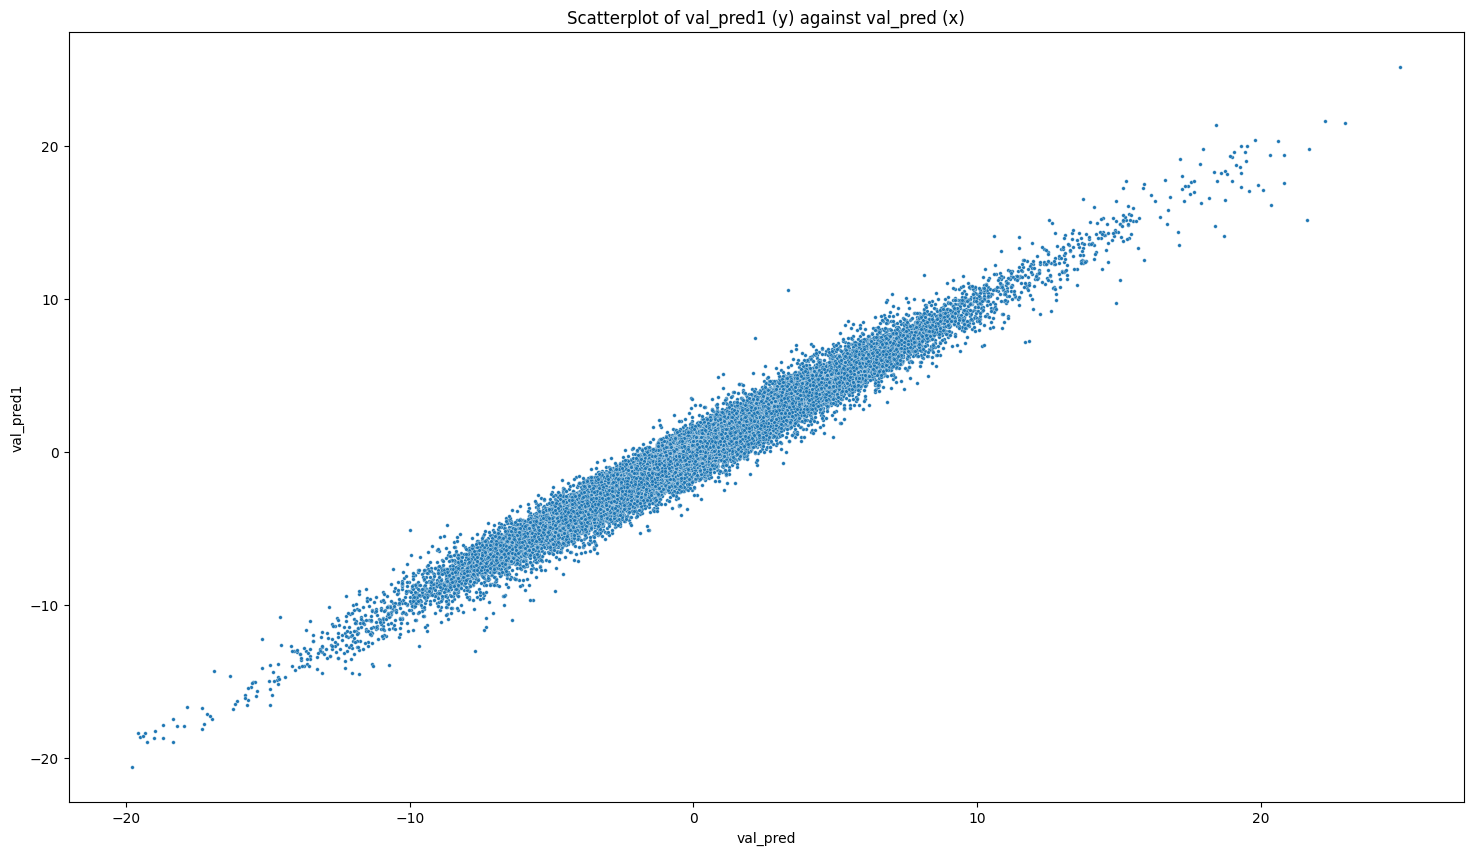

In [136]:
plot_scatterplot(lgbm, x_col="val_pred", y_col="val_pred1")

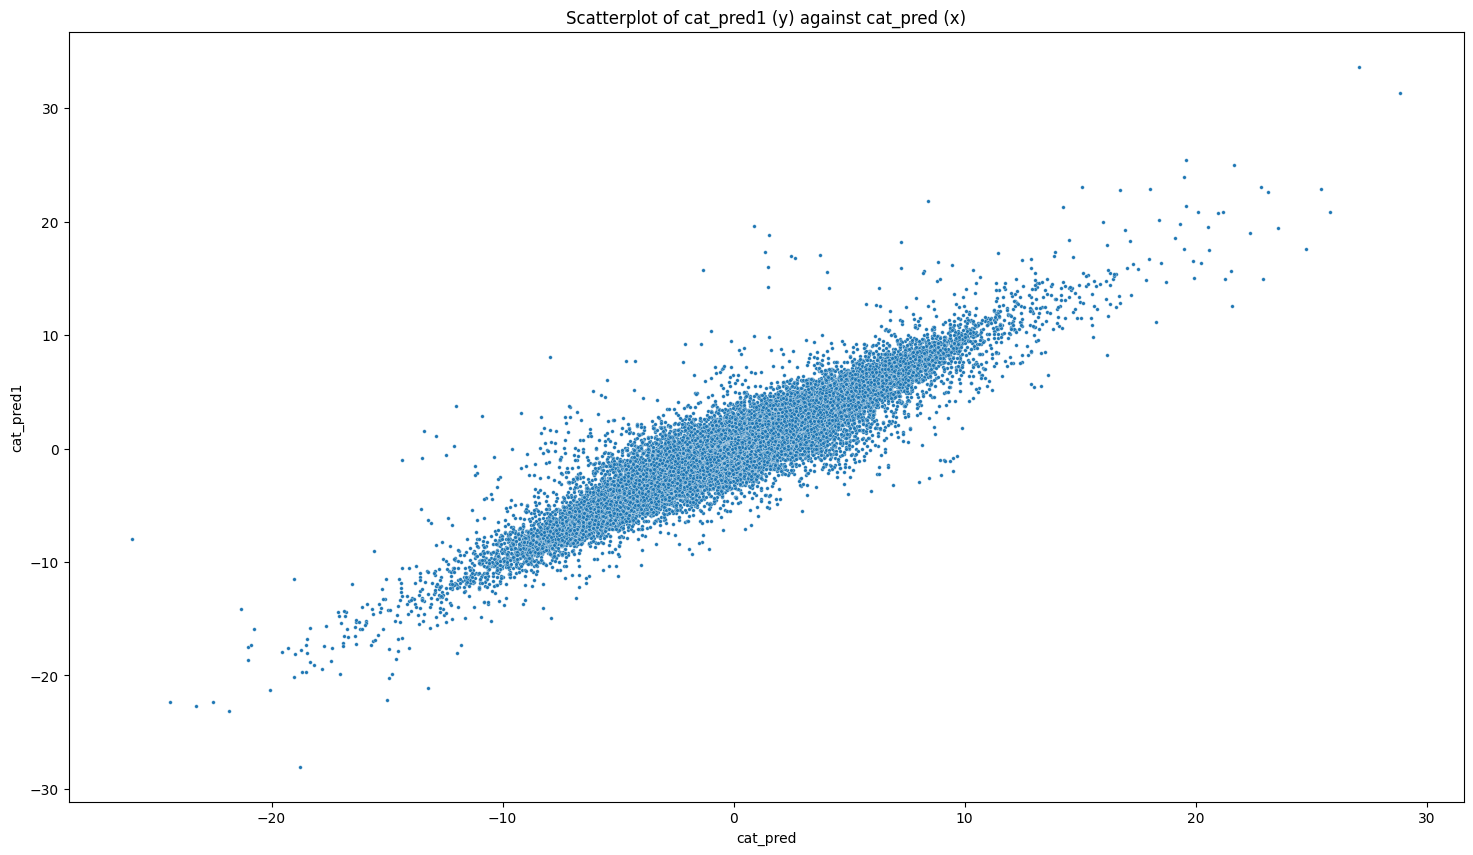

In [135]:
plot_scatterplot(lgbm, x_col="cat_pred", y_col="cat_pred1")

# Try Stack Logistic Regression

In [198]:
lgbm[["cat_pred", "cat_pred1", "val_pred1", "val_pred", "target"]]

,cat_pred,cat_pred1,val_pred1,val_pred,target
0,-0.830997,-0.929836,-1.309504,-1.578251,2.779961
1,-0.810464,-0.884285,-0.726944,-0.964731,4.869700
2,-0.455012,-0.822082,-0.414411,-0.425402,6.250143
3,-0.093208,-0.452160,-0.194242,-0.213853,7.139444
4,0.487792,0.267143,0.533044,0.673420,8.139610
...,...,...,...,...,...
659940,-2.392395,-2.044426,-1.982899,-1.841747,-7.209778
659941,-1.628953,-1.010354,-0.575198,-0.811155,-9.750128
659942,1.252752,0.996103,1.173841,0.984923,3.629923
659943,0.750795,0.261070,0.397068,0.681712,4.760027


In [233]:
final_df = lgbm.merge(train.loc[:, META_COLUMNS + get_cols(train, ["flag", "signal", "bollinger"]) + ["clipped_target"]], on=META_COLUMNS, how="left")

In [234]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GroupKFold

In [235]:
features = ["cat_pred", "cat_pred1", "val_pred1", "val_pred"] + get_cols(train, ["flag", "signal", "bollinger"])

In [236]:
for col in final_df.columns:
    final_df[col] = final_df[col].fillna(final_df[col].mean())

In [237]:
group_kfold = GroupKFold()

In [257]:
%%time
val_pred_list, val_gt_list = [], []
for tr_index, val_index in tqdm(group_kfold.split(final_df, final_df["target"], groups=final_df["stock_id"])):
    X_val = final_df.loc[val_index, features]
    X_train = final_df.loc[tr_index, features]
    y_val = final_df.loc[val_index, "target"]
    y_train = final_df.loc[tr_index, "clipped_target"]
    
    # r = Ridge()
    cb = CatBoostRegressor(verbose=0)
    cb.fit(X_train, y_train)
    val_pred_list.extend(list(cb.predict(X_val)))
    val_gt_list.extend(y_val.tolist())

5it [01:15, 15.11s/it]

CPU times: user 7min 25s, sys: 24.1 s, total: 7min 49s
Wall time: 1min 15s


In [258]:
pd.Series(np.array(val_pred_list) - np.array(val_gt_list)).abs().mean()

5.705074519898685

5.678458627763317